# x00: Exploring fminst data

In [1]:
import os
import os.path
from pathlib import Path
from typing import List, Optional, Callable, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import keras.utils

import cv2
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
%matplotlib inline

In [3]:
BASE_DIR = '{}/code/fashion-mnist'.format(Path.home())
DATA_DIR = os.path.join(BASE_DIR, 'data')
FMNIST_DIR = os.path.join(DATA_DIR, 'external/fashion-mnist')

In [4]:
LABEL_NAMES = ['t-shirt-or-top', 'trouser', 'pullover', 'dress', 'coat', 'sandals', 'shirt', 'sneaker', 'bag',
               'ankle-boost']
LABEL_INDEX = {name: idx for idx, name in enumerate(LABEL_NAMES)}

In [5]:
def fpath(filename):
    return os.path.join(FMNIST_DIR, filename)

In [6]:
# Load training and test data into dataframes
data_train = pd.read_csv(fpath('fashion-mnist_train.csv'))
data_test = pd.read_csv(fpath('fashion-mnist_test.csv'))

# X forms the training images, and y forms the training labels
X_train = np.array(data_train.iloc[:, 1:])
y_train = np.array(data_train.iloc[:, 0])

# X_test forms the test images, and y_test forms the test labels
X_test = np.array(data_test.iloc[:, 1:])
y_test = np.array(data_test.iloc[:, 0])

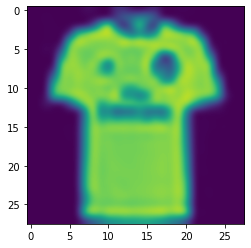

In [7]:
plt.imshow(X_test[0].reshape(-1, 28), interpolation='bicubic')

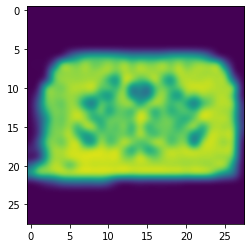

In [8]:
plt.imshow(X_test[6].reshape(-1, 28), interpolation='bicubic')

## Label Distribution

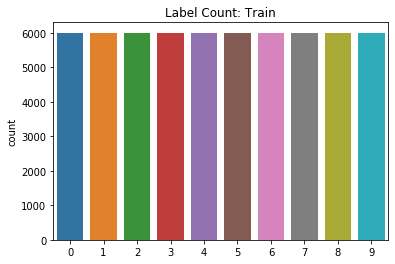

In [9]:
ax = sns.countplot(y_train)
_ = ax.set_title('Label Count: Train')

There are exactly the same number of exampels per class, i.e. 6000, in the training set.

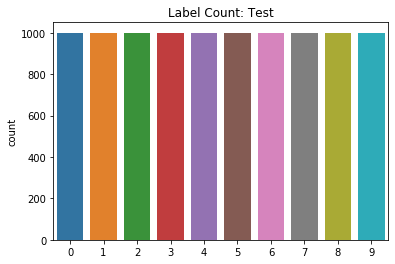

In [10]:
ax = sns.countplot(y_test)
_ = ax.set_title('Label Count: Test')

The same holds for testing, with 1000 examples per class.

Given the even distribution of data, it will be interesting to see which class is harder to predict relative to others, if any.

## Showcase

In [11]:
def show_images(images: List[np.ndarray], cols: int = 1, titles: Optional[List[str]] = None) -> None:
    """Display multiple images arranged as a table.

    Args:
        images (list): list of images to display as numpy arrays.
        cols (int, optional): number of columns.
        titles (list, optional): list of title strings for each image.

    """
    assert ((titles is None) or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1, n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images / float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [12]:
def sample_images(x: np.ndarray, y: np.ndarray, clazz: int, n: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    instances, = np.where(y == clazz)
    examples =  np.random.choice(instances, n)
    return x[examples, :], y[examples], examples

In [13]:
sample_images(X_test, y_test, clazz=0, n=5)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([0, 0, 0, 0, 0]),
 array([7291, 8835, 9094, 3919, 3907]))

In [14]:
def showcase(x: np.ndarray, y: np.ndarray, clazz: int, n: int = 5, transform: Callable[[np.ndarray], np.ndarray] = lambda x: x.reshape(-1, 28)) -> None:
    images, labels, idx = sample_images(x, y, clazz, n)
    images = [transform(image) for image in images]
    titles = ['{}/{}'.format(idx[i], LABEL_NAMES[clazz]) for i in range(len(idx))]
    show_images(images, titles=titles)

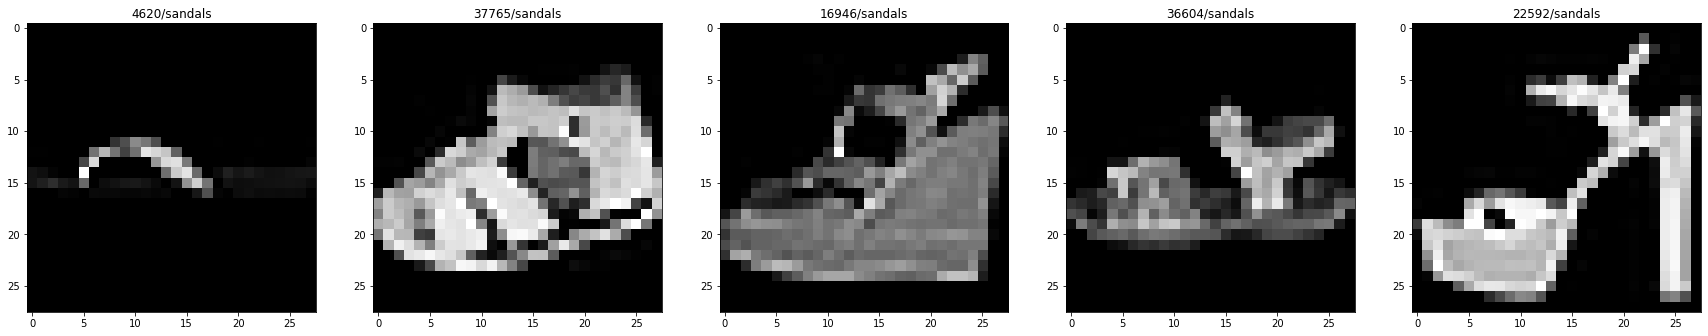

In [15]:
showcase(X_train, y_train, LABEL_INDEX['sandals'])

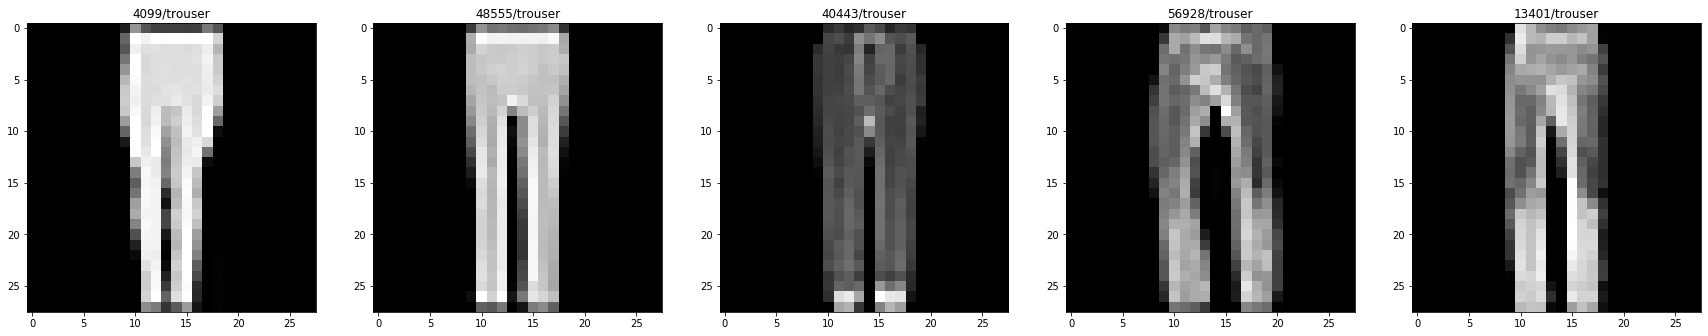

In [16]:
showcase(X_train, y_train, LABEL_INDEX['trouser'])

Some images are move obvious than others. As we'll be using convolutional neural networks, we'll need to resive the images to allow for depth in the models.

## Resizing

There are several options to resize images. We compare two of them: keras image util and OpenCV

In [17]:
def show(img):
    plt.imshow(img, interpolation='bicubic')

In [18]:
def reshape(img_array):
    return img_array.reshape(-1, 28)

In [19]:
samples_idx = np.random.choice(len(y_test), 4)
samples_idx

array([8290, 4553, 5902, 3348])

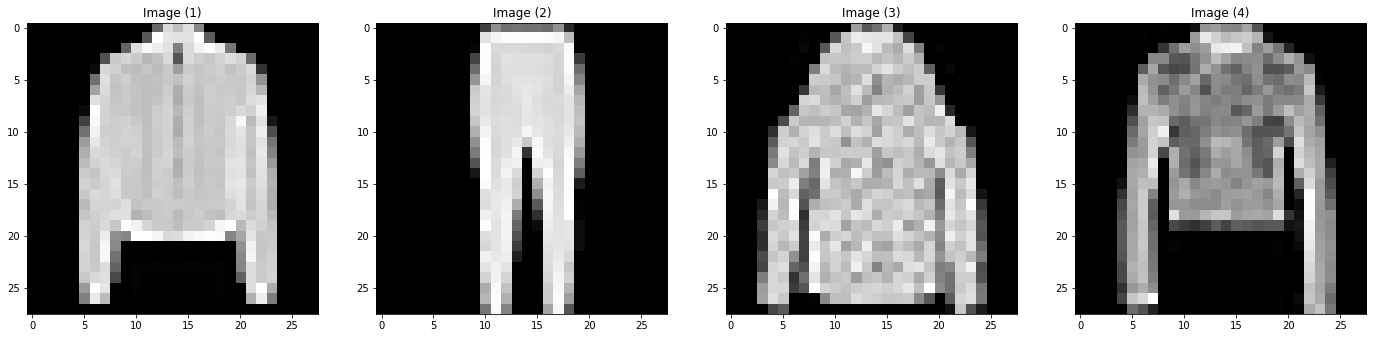

In [20]:
show_images([reshape(X_test[i]) for i in samples_idx])

**Keras Image Util**

In [21]:
def keras_image_resize(image: np.ndarray, new_size: Tuple[int, int]) -> np.ndarray:
    from keras.preprocessing import image as kimage
    image_3d = np.dstack([image] * 3)
    return kimage.img_to_array(kimage.array_to_img(image_3d, scale=True).resize(new_size))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


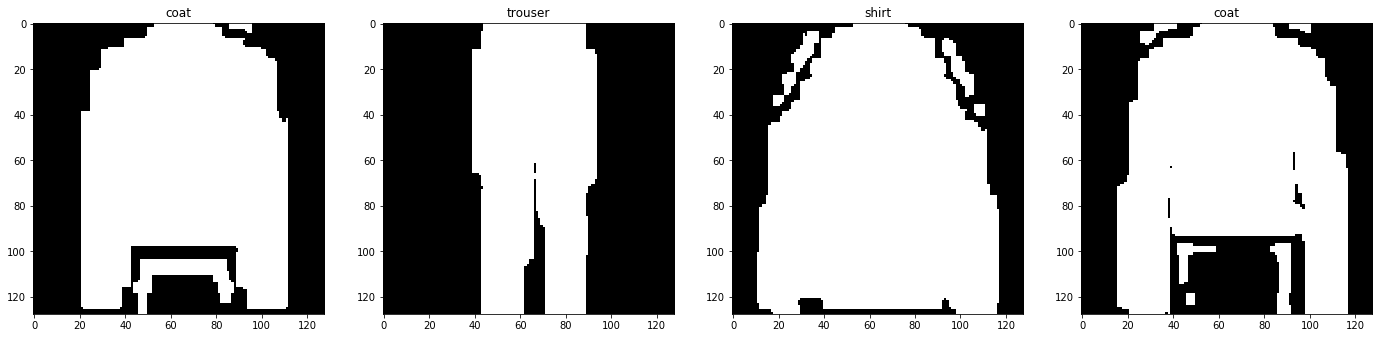

In [22]:
show_images([keras_image_resize(reshape(X_test[i].astype('uint8')), new_size=(128, 128)) for i in samples_idx],
           titles=[LABEL_NAMES[y_test[i]] for i in samples_idx])

The output seems to be quite noisy.

**OpenCV**

In [23]:
def cv2_image_resize(image: np.ndarray, new_size: Tuple[int, int]) -> np.ndarray:
    return cv2.resize(image, new_size)

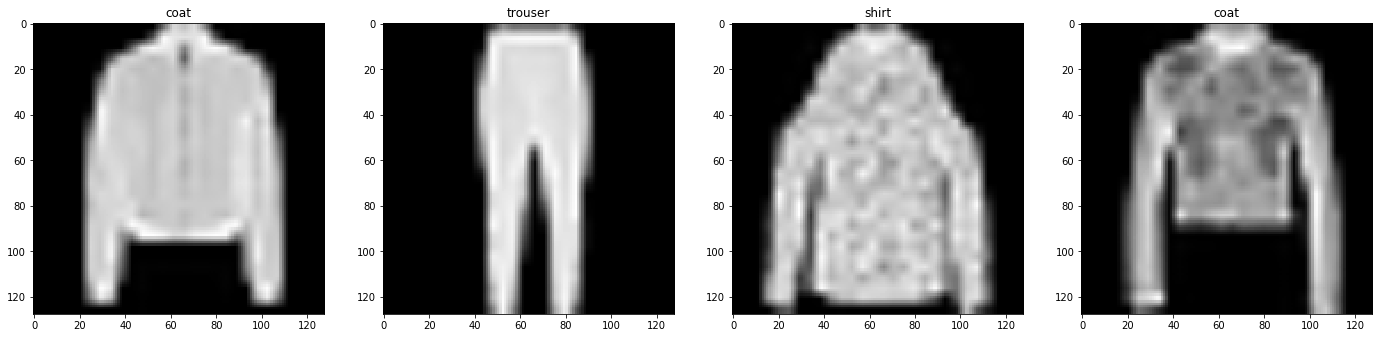

In [24]:
show_images([cv2_image_resize(reshape(X_test[i].astype('uint8')), new_size=(128, 128)) for i in samples_idx],
           titles=[LABEL_NAMES[y_test[i]] for i in samples_idx])

The output from OpenCV seems to be more reliable, i.e. high fidelity. We'll use it for resizing.

## Transformations

We quickly explore some image transformations, for the sake of curiosity.

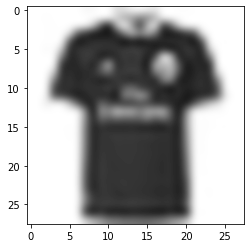

In [25]:
show(reshape((X_test[0]*-1)+255))

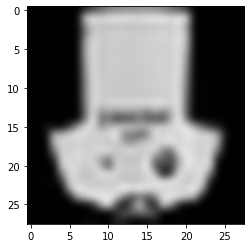

In [26]:
show(np.flip(reshape(X_test[0]), 0))

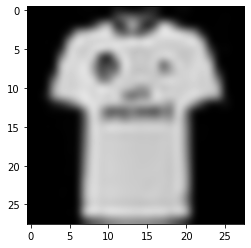

In [27]:
show(np.flip(reshape(X_test[0]), 1))

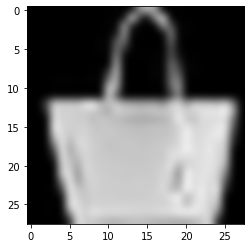

In [28]:
X_S = np.flip(X_test, 0)
show(reshape(X_S[2]))

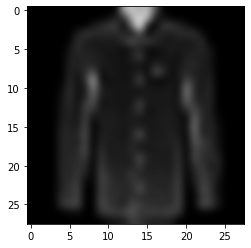

In [29]:
show(reshape(np.concatenate([X_test, X_S])[3333]))

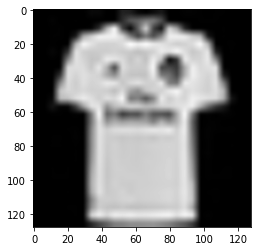

In [30]:
show(cv2.resize(reshape(X_test[0].astype('uint8')), (128, 128)))

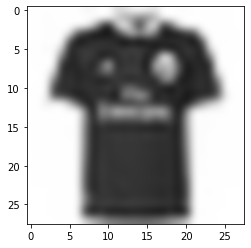

In [31]:
show(np.dstack([(X_test[0]*-1)+255] * 3).reshape((28, 28, 3)))

Trivial transformations are relatively easy with numpy. Cropping, for instance, should be explored as well. Alas, we stop here for now. Image enhancement can be explored in a different notebook.

## Conclusions

  - Labels are pretty much distributed in an equitable manner
  - OpenCV provides reliable resizing